In [1]:
#SECTION 1 - READ THE CSV AND FORMAT A BIT
import csv
from datetime import datetime, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mticker

In [2]:


file = "c://users/vicki/Python Scripts/TemperatureAnalysis/NYCentralPark"
with open(f'{file}.csv', 'r') as t1:
    fileone = t1.readlines()
    t1.close()

tdata = [item[:-1].split(",") for item in fileone]
for index, item in enumerate(tdata):
    itemdate = datetime(int(item[0][:4]), int(item[0][5:7]), int(item[0][8:]))
    itemdayofyear = itemdate.timetuple().tm_yday # get the Day Of Year (DOY) for each date
    tdata[index].append(itemdayofyear)
    tyear = item[0][:4]
    tdata[index].append(tyear) #and isolate just the year and add
    tdata[index].pop(0) #get rid of the original date field

In [3]:
#find and fix the "M"s in the raw data
row_count = 0
h_fix_count = 0
l_fix_count = 0
for i, item in enumerate(tdata):
    hifix = 0
    lowfix = 0
    row_count += 1
    if item[0].lower() == "m":
        for j in range(-10,0): #average the previous ten days and use that to fill the gap
            hifix += int(tdata[i+j][0])
        tdata[i][0] = str(int(hifix/10))
        h_fix_count += 1
    if item[1].lower() == "m":
        for j in range(-10,0):
            lowfix += int(tdata[i+j][1])
        tdata[i][1] = str(int(lowfix/10))
        l_fix_count += 1
tdata[18972][1] = 0
tsum = 0
for j in range(-5,6): #the 10 day average doesn't work for this one date in 1951 so average over both sides of the date
    tsum += int(tdata[18972+j][1])
tdata[18972][1] = str(int(tsum/10))
l_fix_count += 1
print(row_count, h_fix_count, l_fix_count)


44195 6 7


In [4]:
#create a dataframe from the raw temperature data
df = pd.DataFrame(tdata, columns = ["THi","TLo","DOY","Year"])
sorted_data = df.sort_values(["DOY", "Year"]) #sort by DOY
years = df.loc[:,"Year"].unique().tolist() #make a list of the years
sorted_data.reset_index(drop=True, inplace=True)
#convert the text temps to integers
sorted_data.loc[:,"Hi"] = sorted_data.loc[:,"THi"].astype(str).astype(int).copy()
sorted_data.loc[:,"Lo"] = sorted_data.loc[:,"TLo"].astype(str).astype(int).copy()
# get rid of the superfluous text temperature columns
sorted_data.drop(["THi", "TLo"], axis=1, inplace=True)
# create a year sorted view for use in the heatwave / decades chart
year_sorted_data = sorted_data.sort_values(["Year", "DOY"])


In [5]:
#Create a df containing the stats values for each DOY
calcd_day_values = []
for a_day in range(1, 366):
    temp = sorted_data[sorted_data["DOY"]==a_day]
    temp.reset_index(drop=True, inplace=True)
    hi_mean = int(temp["Hi"].mean())
    lo_mean = int(temp["Lo"].mean())
    hcoefficients, hresiduals, _, _, _ = np.polyfit(temp.index,temp["Hi"],1,full=True)
    hi_sd = temp.loc[:,"Hi"].std()
    lcoefficients, lresiduals, _, _, _ = np.polyfit(temp.index,temp["Lo"],1,full=True)
    lo_sd = temp.loc[:,"Lo"].std()
    calcd_day_values.append([str(a_day), hi_mean, hcoefficients[0], hcoefficients[1], hi_sd, lo_mean, lcoefficients[0], lcoefficients[1], lo_sd])
calcd_df = pd.DataFrame(calcd_day_values, columns = ['Day', 'Hi mean', 'H slope', 'H intercept', 'H SD', 'Lo mean', 'L slope', 'L intercept', 'L SD'])
calcd_df.to_csv('NY Central Park.csv') #save for future reference if needed



In [6]:

#79 3/20 0.022280178837555835 48.811949600325164 50
#172 6/21 0.01316217314726971 80.50779027232085 81
#266 9/23 -0.0003454816420544368 73.93808427042408 73
#355 12/21 0.05621189540712624 38.08183173011788 41

print(calcd_df[calcd_df["Day"]=="172"])

     Day  Hi mean   H slope  H intercept      H SD  Lo mean   L slope  \
171  172       80 -0.001246    80.843382  7.467441       64  0.015669   

     L intercept      L SD  
171    63.547487  5.109005  


In [7]:
list_of_hot_days = [] #make a list of the hot days > one sigma 
for year in years:
    for day in range(1,366):
        hi_temp = year_sorted_data[(year_sorted_data.loc[:,"DOY"]==day) & (year_sorted_data.loc[:,"Year"]==year)].loc[:,"Hi"].item()
        hi_mean = calcd_df.loc[day-1, "Hi mean"]
        hi_sd = calcd_df.loc[day-1, "H SD"]
        if hi_temp > hi_mean + hi_sd:
            list_of_hot_days.append([year, day, hi_temp, hi_mean, round(hi_mean + hi_sd, 1)])
hot_days_df = pd.DataFrame(list_of_hot_days, columns=["Year", "DOY", "Hi", "Low", "Hi Mean"])
hot_days_df.head(5)

,Year,DOY,Hi,Low,Hi Mean
0,1900,19,51,38,49.3
1,1900,20,57,38,47.8
2,1900,21,50,38,48.3
3,1900,23,51,40,51.0
4,1900,35,48,37,46.8


In [8]:
#count the number of hot days in each year
hot_days_per_year = {}
for year in years:
    hot_days_per_year[year] = 0
for item in list_of_hot_days: 
    hot_days_per_year[item[0]] += 1
print(hot_days_per_year)

{'1900': 57, '1901': 35, '1902': 31, '1903': 48, '1904': 23, '1905': 47, '1906': 52, '1907': 34, '1908': 46, '1909': 45, '1910': 34, '1911': 40, '1912': 53, '1913': 69, '1914': 53, '1915': 46, '1916': 45, '1917': 25, '1918': 60, '1919': 55, '1920': 45, '1921': 79, '1922': 53, '1923': 50, '1924': 43, '1925': 57, '1926': 31, '1927': 58, '1928': 59, '1929': 70, '1930': 63, '1931': 78, '1932': 67, '1933': 69, '1934': 59, '1935': 54, '1936': 63, '1937': 63, '1938': 75, '1939': 69, '1940': 45, '1941': 74, '1942': 53, '1943': 70, '1944': 77, '1945': 73, '1946': 80, '1947': 64, '1948': 64, '1949': 97, '1950': 61, '1951': 72, '1952': 74, '1953': 97, '1954': 79, '1955': 68, '1956': 52, '1957': 70, '1958': 27, '1959': 85, '1960': 50, '1961': 88, '1962': 48, '1963': 64, '1964': 71, '1965': 60, '1966': 79, '1967': 50, '1968': 65, '1969': 53, '1970': 61, '1971': 65, '1972': 59, '1973': 85, '1974': 66, '1975': 58, '1976': 56, '1977': 71, '1978': 41, '1979': 71, '1980': 72, '1981': 57, '1982': 65, '19

In [9]:
hot_days_per_year_df = pd.DataFrame.from_dict(hot_days_per_year, orient='index')
hot_days_per_year_df.reset_index(inplace=True)
hot_days_per_year_df.rename(columns = {'index':'Year', 0:'Number'}, inplace = True)

In [10]:
hot_days_per_year_df.head(5)

,Year,Number
0,1900,57
1,1901,35
2,1902,31
3,1903,48
4,1904,23


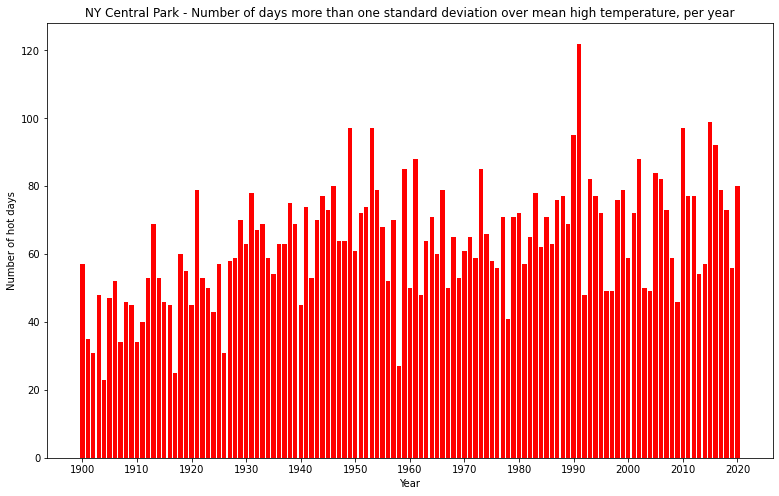

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,8))
fig = plt.bar(hot_days_per_year_df["Year"], hot_days_per_year_df["Number"], color='red', width=.8)
myLocator = mticker.MultipleLocator(10)
ax.xaxis.set_major_locator(myLocator)
ax.set_xlabel('Year')
ax.set_ylabel('Number of hot days')
ax.set_title('NY Central Park - Number of days more than one standard deviation over mean high temperature, per year')
plt.savefig(f'NYCCentralParkhotdaysperyear')

In [12]:
#Count the number of heat waves per year using the hot days df and the calculated values df - new version
#hot days df
#  Year    DOY  Hi  Low  Hi Mean
#0 1900    19  51   38     49.3
#1 1900    20  57   38     47.8
#2 1900    21  50   38     48.3
#3 1900    23  51   40     51.0
#4 1900    35  48   37     46.8
#hot_days_df.iterrows() returns tuples of row index, row data as a pandas series
#(0, Year       1900
#DOY          19
#Hi           51
#Low          38
#Hi Mean    49.3
#Name: 0, dtype: object)

heat_waves_annual_count = {} #count the number of heat waves per year
for year in years:
    heat_waves_annual_count[year] = 0

list_of_heat_waves = []

heat_wave_length = 1
for row in hot_days_df.iterrows(): #the iterrows() function returns a tuple

    if row[0] == 0: #seed variables for the first row
        day1 = row[1]["DOY"]
        year = row[1]["Year"]
        first_row = row
        total_of_temps = row[1]["Hi"] #sum the temps of the days of the heat wave
    else:
        if row[1]["DOY"] == day1 + heat_wave_length: #consecutive day
            heat_wave_length += 1
            total_of_temps += row[1]["Hi"]
            if heat_wave_length == 2:
                heat_waves_annual_count[row[1]["Year"]] += 1 #heat waves starting Dec 31 will count in the following year
        else:
            if heat_wave_length > 1:
                list_of_heat_waves.append([year, day1, round(total_of_temps/heat_wave_length,1), heat_wave_length])
            day1 = row[1]["DOY"] # start the process over
            year = row[1]["Year"]
            total_of_temps = row[1]["Hi"]
            first_row = row
            heat_wave_length = 1            


In [13]:
# lets find out the average temp and the duration of the heat waves, per year
list_of_heat_waves

[['1900', 19, 52.7, 3],
 ['1900', 133, 87.3, 3],
 ['1900', 178, 91.5, 2],
 ['1900', 187, 95.0, 2],
 ['1900', 196, 95.0, 4],
 ['1900', 218, 93.0, 2],
 ['1900', 221, 93.5, 4],
 ['1900', 237, 92.7, 3],
 ['1900', 242, 88.5, 2],
 ['1900', 248, 89.5, 2],
 ['1900', 254, 87.0, 2],
 ['1900', 278, 78.0, 2],
 ['1900', 288, 75.0, 2],
 ['1900', 295, 75.3, 3],
 ['1900', 323, 70.0, 3],
 ['1900', 357, 57.5, 2],
 ['1901', 16, 50.0, 2],
 ['1901', 119, 77.0, 2],
 ['1901', 177, 94.9, 8],
 ['1901', 202, 92.0, 2],
 ['1901', 210, 92.5, 2],
 ['1901', 272, 79.0, 2],
 ['1901', 347, 57.7, 3],
 ['1902', 21, 51.0, 2],
 ['1902', 58, 56.7, 3],
 ['1902', 71, 66.5, 2],
 ['1902', 81, 62.0, 2],
 ['1902', 112, 83.5, 2],
 ['1902', 143, 85.0, 2],
 ['1902', 310, 64.5, 2],
 ['1902', 316, 64.8, 5],
 ['1902', 325, 64.5, 2],
 ['1902', 355, 54.5, 2],
 ['1903', 28, 50.5, 2],
 ['1903', 34, 48.5, 2],
 ['1903', 42, 51.3, 3],
 ['1903', 72, 63.0, 3],
 ['1903', 77, 63.0, 4],
 ['1903', 82, 64.0, 2],
 ['1903', 93, 67.0, 2],
 ['1903', 118

In [14]:
#need to turn the list of heat waves into an annual count
list_of_heat_waves_df = pd.DataFrame(list_of_heat_waves, columns=["Year", "Start","Avg Temp", "Length"])
list_of_heat_waves_df.head(5)

,Year,Start,Avg Temp,Length
0,1900,19,52.7,3
1,1900,133,87.3,3
2,1900,178,91.5,2
3,1900,187,95.0,2
4,1900,196,95.0,4


In [15]:
list_of_heat_waves_df.head(5)

,Year,Start,Avg Temp,Length
0,1900,19,52.7,3
1,1900,133,87.3,3
2,1900,178,91.5,2
3,1900,187,95.0,2
4,1900,196,95.0,4


In [16]:
#make a list of the number of heatwaves per year
heat_wave_annual_count = {}
for year in years:
    heat_wave_annual_count[year] = list_of_heat_waves_df[list_of_heat_waves_df["Year"]==year]["Year"].count()
hw_annual_count_df = pd.DataFrame(heat_wave_annual_count, index= [0]).T
hw_annual_count_df.reset_index(inplace=True)
hw_annual_count_df.rename(columns = {'index':'Year', 0:'Number'}, inplace = True)
hw_annual_count_df.head(5)

,Year,Number
0,1900,16
1,1901,7
2,1902,10
3,1903,14
4,1904,6


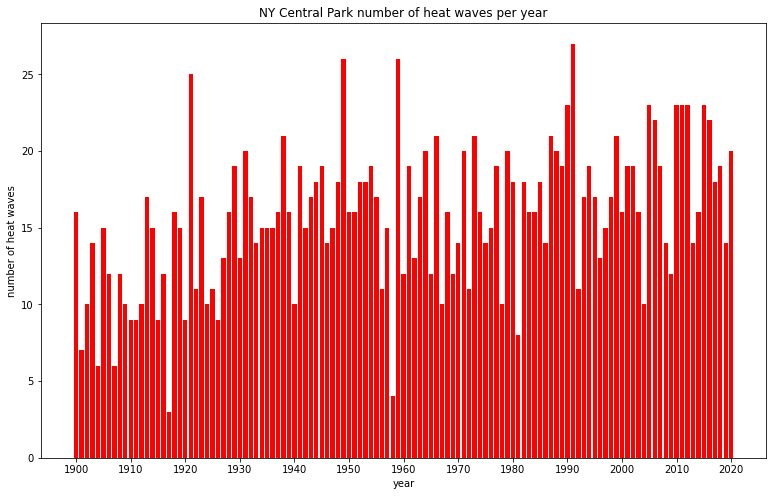

In [17]:
#plot the number of heatwaves per year

wavefig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,8))
myLocator = mticker.MultipleLocator(10)
ax.xaxis.set_major_locator(myLocator)
ax.set_xlabel('year')
ax.set_ylabel('number of heat waves')
ax.set_title('NY Central Park number of heat waves per year')
wavefig = plt.bar(years, hw_annual_count_df["Number"], color='red')
#ax.plot(years, heat_waves_annual_list)
plt.savefig(f'CentralParkNYheatwavesyear')


In [18]:
heat_waves_by_decade = {} 
pointer = 0
for index in range(12):
    heat_waves_by_decade[index*10+1900] = 0
    for index2 in range(10):
        heat_waves_by_decade[index*10+1900] += hw_annual_count_df[hw_annual_count_df.index == pointer]["Number"].item() #calculate heat waves per 10 year period
        pointer += 1
heat_waves_by_decade

{1900: 108,
 1910: 115,
 1920: 140,
 1930: 162,
 1940: 171,
 1950: 160,
 1960: 152,
 1970: 160,
 1980: 168,
 1990: 180,
 2000: 170,
 2010: 195}

In [19]:
hwdf = pd.DataFrame.from_dict(heat_waves_by_decade, orient='index', columns=["Number"])
hwdf.reset_index(inplace=True)
hwdf.loc[:,"Decade"] = hwdf.loc[:,"index"].astype(int).astype(str).copy()
hwdf.drop("index", axis=1, inplace=True)
hwdf

,Number,Decade
0,108,1900
1,115,1910
2,140,1920
3,162,1930
4,171,1940
5,160,1950
6,152,1960
7,160,1970
8,168,1980
9,180,1990


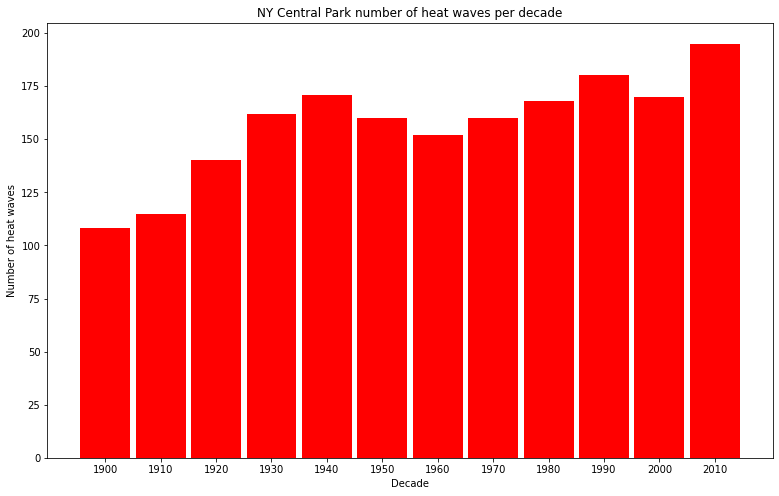

In [20]:
wavefig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(13,8))
wavefig2 = plt.bar(hwdf.loc[:,"Decade"], hwdf.loc[:,"Number"], color='red', width=.9)
ax2.set_xlabel('Decade')
ax2.set_ylabel('Number of heat waves')
ax2.set_title('NY Central Park number of heat waves per decade')
plt.savefig(f'CentralParkTemphotheatwavesdecade')

In [21]:
for item in list_of_heat_waves:
    print(item)

['1900', 19, 52.7, 3]
['1900', 133, 87.3, 3]
['1900', 178, 91.5, 2]
['1900', 187, 95.0, 2]
['1900', 196, 95.0, 4]
['1900', 218, 93.0, 2]
['1900', 221, 93.5, 4]
['1900', 237, 92.7, 3]
['1900', 242, 88.5, 2]
['1900', 248, 89.5, 2]
['1900', 254, 87.0, 2]
['1900', 278, 78.0, 2]
['1900', 288, 75.0, 2]
['1900', 295, 75.3, 3]
['1900', 323, 70.0, 3]
['1900', 357, 57.5, 2]
['1901', 16, 50.0, 2]
['1901', 119, 77.0, 2]
['1901', 177, 94.9, 8]
['1901', 202, 92.0, 2]
['1901', 210, 92.5, 2]
['1901', 272, 79.0, 2]
['1901', 347, 57.7, 3]
['1902', 21, 51.0, 2]
['1902', 58, 56.7, 3]
['1902', 71, 66.5, 2]
['1902', 81, 62.0, 2]
['1902', 112, 83.5, 2]
['1902', 143, 85.0, 2]
['1902', 310, 64.5, 2]
['1902', 316, 64.8, 5]
['1902', 325, 64.5, 2]
['1902', 355, 54.5, 2]
['1903', 28, 50.5, 2]
['1903', 34, 48.5, 2]
['1903', 42, 51.3, 3]
['1903', 72, 63.0, 3]
['1903', 77, 63.0, 4]
['1903', 82, 64.0, 2]
['1903', 93, 67.0, 2]
['1903', 118, 79.3, 3]
['1903', 138, 86.2, 5]
['1903', 182, 91.5, 2]
['1903', 189, 93.0, 3]
[

In [22]:
day_index = 5 #change this number to pick different days from the key_dates list
#0, 3, 4, 5, 7, 10
key_dates = [[1900, 1, 1], [1900, 2, 14], [1900, 3, 3], [1900, 3, 20], [1900, 6, 21], [1900, 7, 4], [1900, 8, 13], [1900, 9, 23], [1900, 10, 15], [1900, 11, 1], [1900, 12, 21], [1900, 12, 25]]

key_days = []
title_days = []
for item in key_dates:
    itemdate = datetime(item[0], item[1], item[2])
    titledate = f"{item[1]}/{item[2]}"
    key_days.append(itemdate.timetuple().tm_yday)
    title_days.append(titledate)
key_days.sort()
print(key_days)
print(title_days)
hot_days_df

[1, 45, 62, 79, 172, 185, 225, 266, 288, 305, 355, 359]
['1/1', '2/14', '3/3', '3/20', '6/21', '7/4', '8/13', '9/23', '10/15', '11/1', '12/21', '12/25']


,Year,DOY,Hi,Low,Hi Mean
0,1900,19,51,38,49.3
1,1900,20,57,38,47.8
2,1900,21,50,38,48.3
3,1900,23,51,40,51.0
4,1900,35,48,37,46.8
...,...,...,...,...,...
7683,2020,347,58,43,52.7
7684,2020,348,62,42,52.2
7685,2020,359,59,41,50.5
7686,2020,360,61,40,49.8


In [23]:
# determine the DOY for specific key dates througout the year
# holidays - Jan 1, Valentine's Day, July 4, Labor Day
holidays = [[1900, 1, 1], [1900, 2, 14], [1900, 7, 4], [1900, 9, 3]]
# birthdays - Frank's, Mine, Emily's, John's
birthdays = [[1900, 1, 4], [1900, 3, 3], [1900, 8, 12], [1900, 11, 1]]
# solar events - solictice, equinox
key_dates = [[1900, 3, 20], [1900, 6, 21], [1900, 9, 23], [1900, 12, 21]]

key_days = []
title_days = []
for item in key_dates:
    itemdate = datetime(item[0], item[1], item[2])
    titledate = f"{item[1]}/{item[2]}"
    key_days.append(itemdate.timetuple().tm_yday)
    title_days.append(titledate)
key_days.sort()

79 3/20 0.022280178837555835 48.811949600325164 50
172 6/21 0.01316217314726971 80.50779027232085 81
266 9/23 -0.0003454816420544368 73.93808427042408 73
355 12/21 0.05621189540712624 38.08183173011788 41


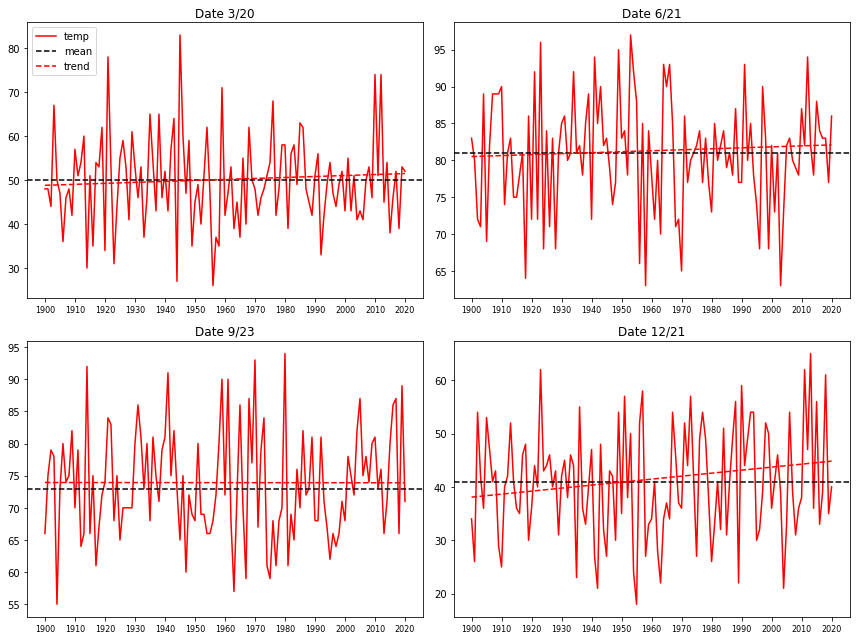

In [24]:
# plot four key day's hi temps in a 2 x 2 set of sub-plots

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for day_index in range(0, 4):
#get the temp data for a particular day across all years
    day_to_plot = key_days[day_index]
    day_temps = sorted_data[sorted_data["DOY"]==day_to_plot].copy()
    day_temps.reset_index(drop=True, inplace=True)
    hi_mean = calcd_df.loc[day_to_plot, "Hi mean"]
    h = day_temps["Hi"]
    x = [x for x in range(0, len(day_temps["Hi"]))]

# numpy.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
    hc0 = calcd_df.loc[day_to_plot, "H slope"]
    hc1 = calcd_df.loc[day_to_plot, "H intercept"]
    print(day_to_plot, title_days[day_index], hc0, hc1, hi_mean)
    a = int(day_index/2)
    b = day_index%2
    axes[a][b].plot(x, h, 'r', label='temp')
    axes[a][b].title.set_text(f'Date {title_days[day_index]}')
    axes[a][b].axhline(hi_mean, color='k', linestyle='--', label='mean')
    axes[a][b].plot([hc0*lx + hc1 for lx in range(len(x))], 'r--', label='trend')
    if day_index == 0:
         axes[a][b].legend()
    axes[a][b].set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
    axes[a][b].set_xticklabels([xlable for xlable in years if xlable[3:4]=='0'], fontsize=8)
    fig.tight_layout()
    plt.savefig(f'NYCCentralParkTempkeydays')


7/4 185
Hi coefficients 0.017809239940387044 82.65871833084951
Hi NRMSE: 0.17372884716053022
Lo coefficients 0.03303752879013649 64.98469042135213


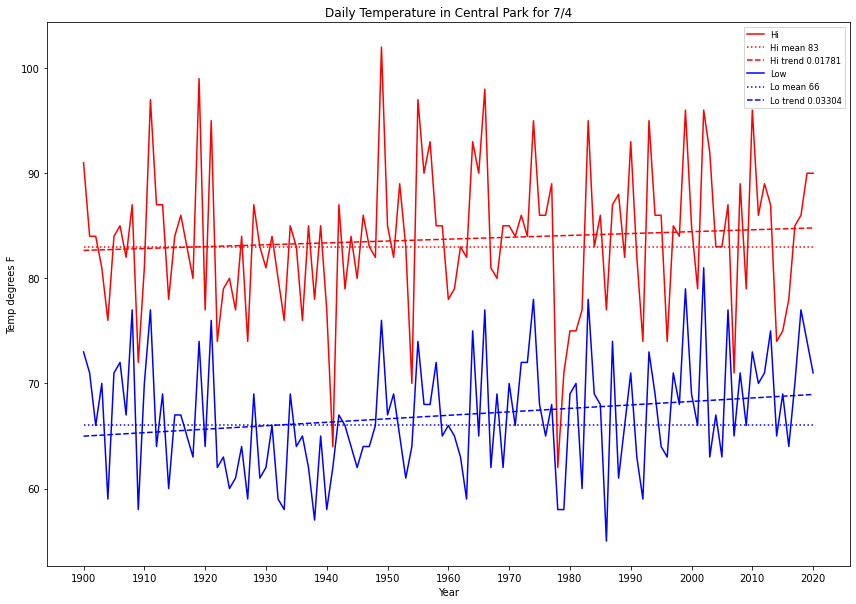

In [25]:
item = [2021,7,4]
itemdate = datetime(item[0], item[1], item[2])
day_to_plot = itemdate.timetuple().tm_yday
titledate = f"{item[1]}/{item[2]}"
print(titledate, day_to_plot)

day_temps = sorted_data[sorted_data["DOY"]==day_to_plot].copy()
day_temps.reset_index(drop=True, inplace=True)

#calc the means
hi_mean = int(day_temps["Hi"].mean())
lo_mean = int(day_temps["Lo"].mean())


h = day_temps["Hi"]
l = day_temps["Lo"]
x = day_temps["Year"]

hcoefficients, hresiduals, _, _, _ = np.polyfit(day_temps.index,h,1,full=True)
hmse = hresiduals[0]/(len(day_temps.index))
hnrmse = np.sqrt(hmse)/(h.max() - h.min())
hnrmse
print(f'Hi coefficients {hcoefficients[0]} {hcoefficients[1]}')
print('Hi NRMSE: ' + str(hnrmse))

lcoefficients, lresiduals, _, _, _ = np.polyfit(day_temps.index,l,1,full=True)
lmse = lresiduals[0]/(len(day_temps.index))
lnrmse = np.sqrt(lmse)/(l.max() - l.min())
print(f'Lo coefficients {lcoefficients[0]} {lcoefficients[1]}')
#print('Lo NRMSE: ' + str(lnrmse))

#all the plotting code below needs to be in one cell in order to properly manipulate the subplot
fig, axes = plt.subplots(figsize=(12,8.5))
axes.plot(x, h, 'r', label='Hi')
axes.plot([hi_mean for lm in range(len(x))], "r:", label=f'Hi mean {hi_mean}')
axes.plot([hcoefficients[0]*lx + hcoefficients[1] for lx in range(len(x))], 'r--', label=f'Hi trend {round(hcoefficients[0],5)}')

axes.plot(x, l, 'b', label="Low")
axes.plot([lo_mean for lm in range(len(x))], "b:", label=f'Lo mean {lo_mean}')
axes.plot([lcoefficients[0]*lx + lcoefficients[1] for lx in range(len(x))], 'b--', label=f'Lo trend {round(lcoefficients[0],5)}')

axes.set_xlabel('Year')
axes.set_ylabel('Temp degrees F')
axes.set_title(f"Daily Temperature in Central Park for {titledate}")
axes.legend(loc="best", fontsize='small')
# set the x axis to every 10 years so the labels don't overlap
myLocator = mticker.MultipleLocator(10)
axes.xaxis.set_major_locator(myLocator)
fig.tight_layout()
plt.savefig(f'NYCCentralParkTemp{day_to_plot}')

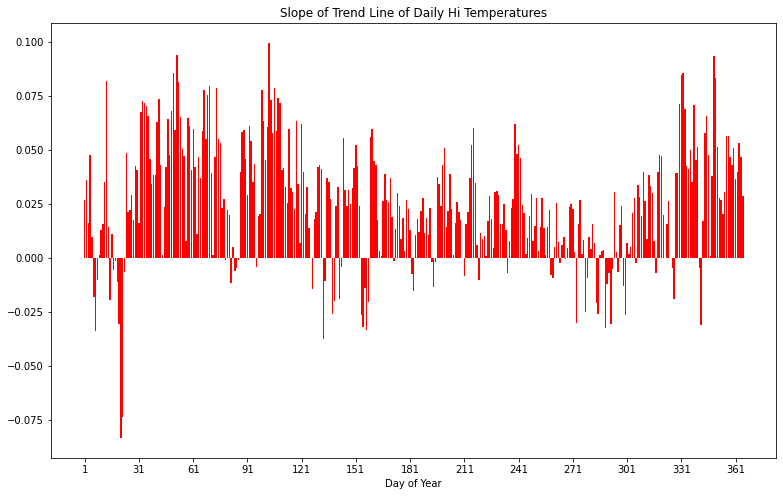

In [26]:
#This section plots the slope of the trend lines as a vertical bar chart
#and compares the overall change in hi and low temps over the 
#122 years of the data

fig3, axes3 = plt.subplots(figsize=(13,8))
fig3 = plt.bar(calcd_df["Day"], calcd_df["H slope"], color='red')
axes3.plot()
myLocator3 = mticker.MultipleLocator(30)
axes3.xaxis.set_major_locator(myLocator3)
axes3.set_xlabel('Day of Year')
axes3.set_title(f"Slope of Trend Line of Daily Hi Temperatures")
plt.savefig(f'NYCCentralParkHiTempTrends')

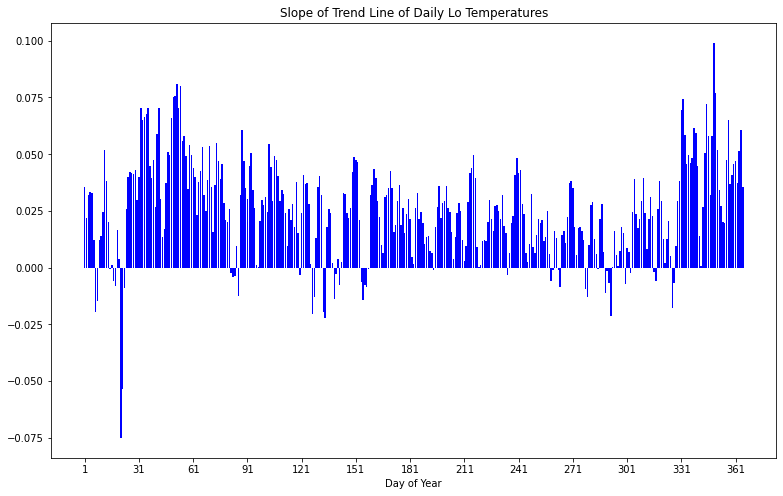

In [27]:

fig3, axes3 = plt.subplots(figsize=(13,8))
fig3 = plt.bar(calcd_df["Day"], calcd_df["L slope"], color='blue')
axes3.plot()
myLocator3 = mticker.MultipleLocator(30)
axes3.xaxis.set_major_locator(myLocator3)
axes3.set_xlabel('Day of Year')
axes3.set_title(f"Slope of Trend Line of Daily Lo Temperatures")
plt.savefig(f'NYCentralParkLoTempTrends')

In [28]:
sum_low_trend = calcd_df["L slope"].sum()
mean_low_trend = calcd_df["L slope"].mean()
sum_high_trend = calcd_df["H slope"].sum()
mean_high_trend = calcd_df["H slope"].mean()
print(f"Hi sum {sum_high_trend}, mean {mean_high_trend}, Lo sum {sum_low_trend}, mean {mean_low_trend}")

Hi sum 9.190651673214909, mean 0.02517986759784907, Lo sum 9.156713182495519, mean 0.02508688543149456


In [29]:
#plot the average temperature, aka intensity, and the average duration of the heat waves per decade
#list_of_heat_waves_df.head(5)
#   Year   Start   Avg Temp  Length
#0  1900    19      52.7      3
#1  1900   133      87.3      3

#make a list of the number of heatwaves per year
hw_intensity = {}
hw_duration = {}
for year in years:
    hw_intensity[year] = list_of_heat_waves_df[list_of_heat_waves_df["Year"]==year]["Avg Temp"].sum()
    hw_intensity[year] = round(hw_intensity[year]/list_of_heat_waves_df[list_of_heat_waves_df["Year"]==year]["Avg Temp"].count(), 3)
    hw_duration[year] = list_of_heat_waves_df[list_of_heat_waves_df["Year"]==year]["Length"].sum()
    hw_duration[year] = round(hw_duration[year]/list_of_heat_waves_df[list_of_heat_waves_df["Year"]==year]["Length"].count(), 3)
hw_intensity_df = pd.DataFrame([hw_intensity, hw_duration], index=[0, 1]).T
hw_intensity_df.reset_index(inplace=True)   
hw_intensity_df.rename(columns = {'index':'Year', 0:'Avg Temp', 1:'Avg Duration'}, inplace = True)
hw_intensity_df.head(5)



,Year,Avg Temp,Avg Duration
0,1900,82.594,2.562
1,1901,77.586,3.000
2,1902,65.300,2.400
3,1903,69.971,2.857
4,1904,81.367,2.167


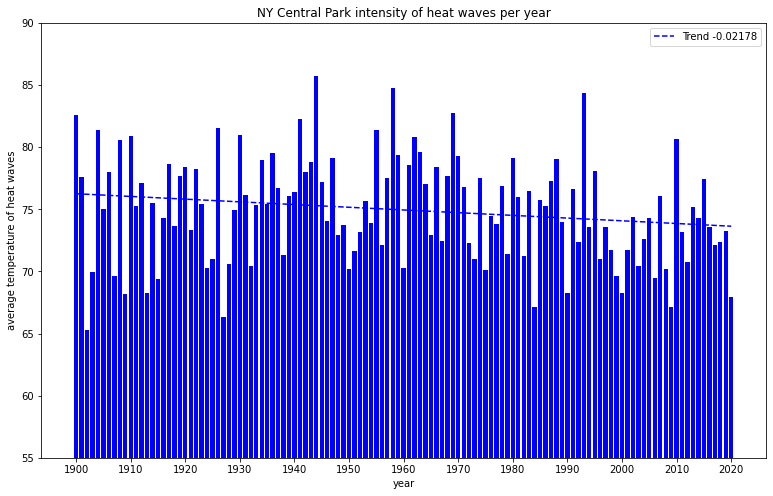

In [30]:
#plot the intensity of heat waves per year

wavefig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,8))
myLocator = mticker.MultipleLocator(10)
ax.xaxis.set_major_locator(myLocator)
ax.set_xlabel('year')
ax.set_ylabel('average temperature of heat waves')
ax.set_title('NY Central Park intensity of heat waves per year')
ax = plt.gca()
ax.set_ylim([55, 90])
wavefig = plt.bar(years, hw_intensity_df["Avg Temp"], color='b')
h = hw_intensity_df["Avg Temp"]
hcoefficients, hresiduals, _, _, _ = np.polyfit(hw_intensity_df.index,h,1,full=True)
ax.plot([hcoefficients[0]*lx + hcoefficients[1] for lx in range(len(years))], 'b--', label=f'Trend {round(hcoefficients[0],5)}')
ax.legend()

plt.savefig(f'CentralParkNYheatwavesintensityyear')

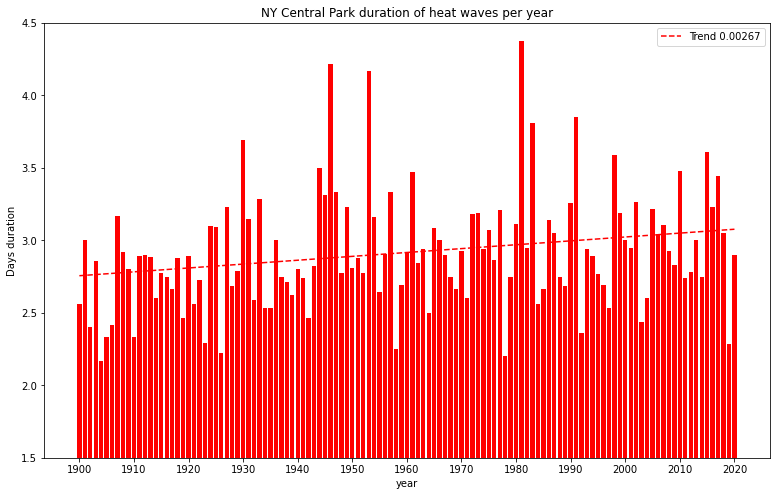

In [31]:
#plot the duration of heat waves per year

wavefig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,8))
myLocator = mticker.MultipleLocator(10)
ax.xaxis.set_major_locator(myLocator)
ax.set_xlabel('year')
ax.set_ylabel('Days duration')
ax.set_title('NY Central Park duration of heat waves per year')
ax = plt.gca()
ax.set_ylim([1.5, 4.5])
wavefig = plt.bar(years, hw_intensity_df["Avg Duration"], color='red')
h = hw_intensity_df["Avg Duration"]
hcoefficients, hresiduals, _, _, _ = np.polyfit(hw_intensity_df.index,h,1,full=True)
ax.plot([hcoefficients[0]*lx + hcoefficients[1] for lx in range(len(years))], 'r--', label=f'Trend {round(hcoefficients[0],5)}')
ax.legend()

plt.savefig(f'CentralParkNYheatwavesdurationyear')

In [32]:
#get the heat wave intensity per decade
#hw_intensity_df.head(5)
#    Year   Avg Temp   Avg Duration
#0   1900    82.594       2.562
#1   1901    77.586       3.000
#2   1902    65.300       2.400
#3   1903    69.971       2.857
#4   1904    81.367       2.167

decades = ['1900', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010']

hw_int_dec_df = pd.DataFrame(
    columns=['Avg Intensity', 'Avg Duration'],
    index=decades)


for indx in range(12):
    decade = indx*10+1900
    hw_int_dec_df.loc[str(decade), "Avg Intensity"] = hw_intensity_df.loc[(hw_intensity_df["Year"] >= str(decade)) & (hw_intensity_df["Year"] < str(decade+10)), "Avg Temp"].sum() / hw_intensity_df.loc[(hw_intensity_df["Year"] >= str(decade)) & (hw_intensity_df["Year"] < str(decade+10)), "Avg Temp"].count()
    hw_int_dec_df.loc[str(decade), "Avg Duration"] = hw_intensity_df.loc[(hw_intensity_df["Year"] >= str(decade)) & (hw_intensity_df["Year"] < str(decade+10)), "Avg Duration"].sum() / hw_intensity_df.loc[(hw_intensity_df["Year"] >= str(decade)) & (hw_intensity_df["Year"] < str(decade+10)), "Avg Duration"].count()
    
hw_int_dec_df

,Avg Intensity,Avg Duration
1900,74.831,2.662
1910,75.0839,2.7141
1920,74.0191,2.7591
1930,76.0972,2.8871
1940,77.8247,3.12
1950,75.9694,2.9621
1960,77.053,2.9078
1970,74.3602,2.8938
1980,75.1271,3.1096
1990,73.9281,3.0081


In [33]:
decades

['1900',
 '1910',
 '1920',
 '1930',
 '1940',
 '1950',
 '1960',
 '1970',
 '1980',
 '1990',
 '2000',
 '2010']

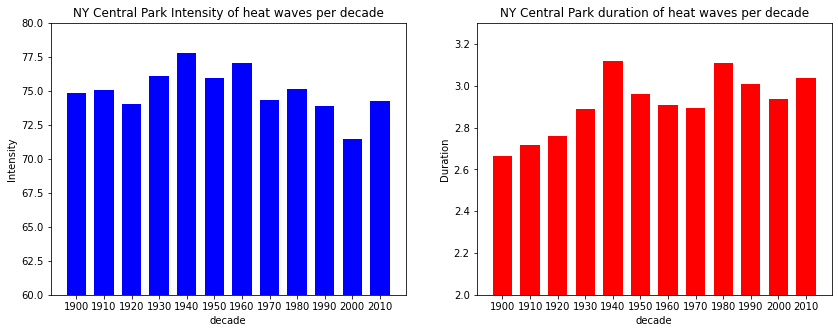

In [34]:
#plot intensity and duration of heat waves per decade

wavefig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax[0].set_xlabel('decade')
ax[0].set_ylabel('Intensity')
ax[0].set_title('NY Central Park Intensity of heat waves per decade')
ax[0].set_ylim([60, 80])
ax[0].bar(decades, hw_int_dec_df["Avg Intensity"], width=.7, color='b')
#h = hw_int_dec_df["Avg Intensity"]
#hcoefficients, hresiduals, _, _, _ = np.polyfit(hw_int_dec_df.index,h,1,full=True)
#ax[0].plot([hcoefficients[0]*lx + hcoefficients[1] for lx in range(len(years))], 'b--', label=f'Trend {round(hcoefficients[0],5)}')
#ax[0].legend()
ax[1].set_xlabel('decade')
ax[1].set_ylabel('Duration')
ax[1].set_title('NY Central Park duration of heat waves per decade')
ax[1].set_ylim([2, 3.3])
ax[1].bar(decades, hw_int_dec_df["Avg Duration"], width=.7, color="r")

plt.savefig(f'CentralParkNYheatwavesdurationdecade')

In [35]:
#Read the heat wave intensity and duration data from Cornell U

cornellintdur_df = pd.read_csv("CornellHWIntDur.csv")
cornellintdur_df.rename(columns= {"Unnamed: 0": "Year", "Avg Intensity": "C Avg Int", "Avg Duration": "C Avg Dur"}, inplace= True)
cornellintdur_df.drop("Year", axis=1, inplace=True)
cornellintdur_df


#Remove the soon to be extra year column
hw_int_dec_df.reset_index(inplace=True)
hw_int_dec_df.rename(columns={"index": "Year"}, inplace=True)
hw_int_dec_df

#combine the intensity and duration data from cornell with central park and average them
bothsites_df = pd.concat([hw_int_dec_df, cornellintdur_df],axis=1, join='inner')
bothsites_df["B Avg Int"] = (bothsites_df["Avg Intensity"]+bothsites_df["C Avg Int"])/2
bothsites_df["B Avg Dur"] = (bothsites_df["Avg Duration"]+bothsites_df["C Avg Dur"])/2
bothsites_df


,Year,Avg Intensity,Avg Duration,C Avg Int,C Avg Dur,B Avg Int,B Avg Dur
0,1900,74.831,2.662,73.8994,3.0606,74.3652,2.8613
1,1910,75.0839,2.7141,72.8873,3.3572,73.9856,3.03565
2,1920,74.0191,2.7591,71.8341,3.0488,72.9266,2.90395
3,1930,76.0972,2.8871,75.8880,3.5120,75.9926,3.19955
4,1940,77.8247,3.12,76.7799,3.4888,77.3023,3.3044
5,1950,75.9694,2.9621,73.4848,3.0133,74.7271,2.9877
6,1960,77.053,2.9078,72.2835,2.8449,74.66825,2.87635
7,1970,74.3602,2.8938,68.6343,2.9650,71.49725,2.9294
8,1980,75.1271,3.1096,71.5820,2.7232,73.35455,2.9164
9,1990,73.9281,3.0081,67.5241,2.9120,70.7261,2.96005


In [49]:
cornell_hwdf = pd.read_csv('CornellHWDF.csv')
cornell_hwdf.drop("Unnamed: 0", axis=1, inplace=True)
cornell_hwdf

,Number,Decade
0,169,1900
1,181,1910
2,190,1920
3,232,1930
4,222,1940
5,175,1950
6,135,1960
7,111,1970
8,115,1980
9,122,1990


In [50]:
cornell_hwdf.drop("Decade", axis=1, inplace=True)
cornell_hwdf.rename(columns={"Number": "CU Number"}, inplace=True)
cornell_hwdf

,Number
0,169
1,181
2,190
3,232
4,222
5,175
6,135
7,111
8,115
9,122


In [53]:
bothsites_hwdf = pd.concat([hwdf, cornell_hwdf],axis=1, join='inner')
bothsites_hwdf

,Number,Decade,CU Number
0,108,1900,169
1,115,1910,181
2,140,1920,190
3,162,1930,232
4,171,1940,222
5,160,1950,175
6,152,1960,135
7,160,1970,111
8,168,1980,115
9,180,1990,122


In [55]:
bothsites_hwdf["Both HW Number"] = (bothsites_hwdf["Number"]+bothsites_hwdf["CU Number"])/2

In [59]:
bothsites_hwdf

,Number,Decade,CU Number,Both HW Number
0,108,1900,169,138.5
1,115,1910,181,148.0
2,140,1920,190,165.0
3,162,1930,232,197.0
4,171,1940,222,196.5
5,160,1950,175,167.5
6,152,1960,135,143.5
7,160,1970,111,135.5
8,168,1980,115,141.5
9,180,1990,122,151.0


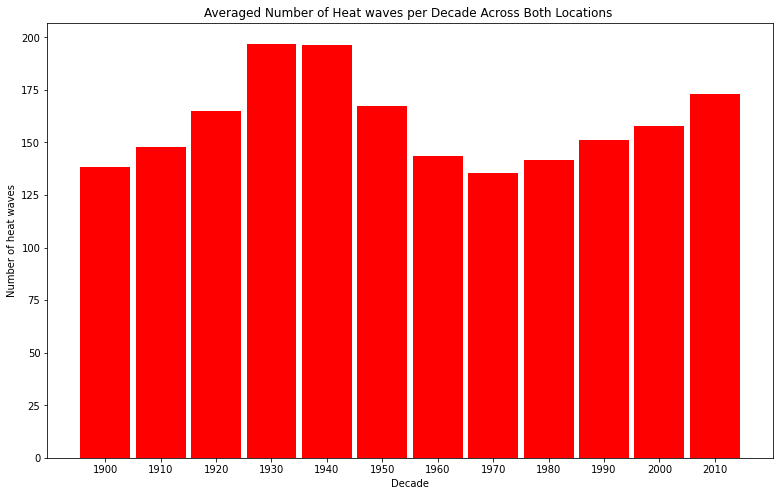

In [61]:
wavefig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(13,8))
wavefig2 = plt.bar(bothsites_hwdf.loc[:,"Decade"], bothsites_hwdf.loc[:,"Both HW Number"], color='red', width=.9)
ax2.set_xlabel('Decade')
ax2.set_ylabel('Number of heat waves')
ax2.set_title('Averaged Number of Heat waves per Decade Across Both Locations ')
plt.savefig(f'BothTemphotheatwavesdecade')

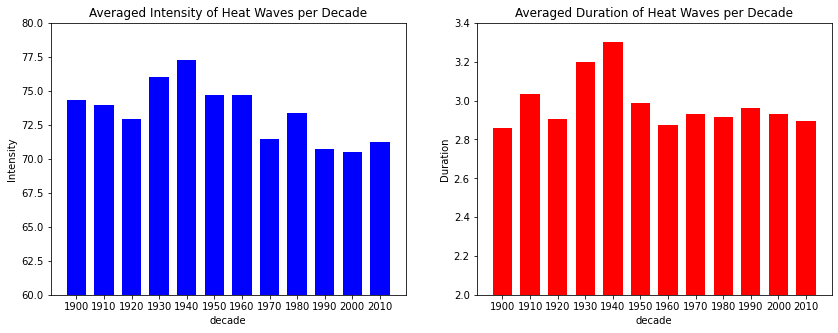

In [56]:
#plot both sites averaged intensity and duration of heat waves per decade

wavefig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax[0].set_xlabel('decade')
ax[0].set_ylabel('Intensity')
ax[0].set_title('Averaged Intensity of Heat Waves per Decade')
ax[0].set_ylim([60, 80])
ax[0].bar(decades, bothsites_df["B Avg Int"], width=.7, color='b')

ax[1].set_xlabel('decade')
ax[1].set_ylabel('Duration')
ax[1].set_title('Averaged Duration of Heat Waves per Decade')
ax[1].set_ylim([2, 3.4])
ax[1].bar(decades, bothsites_df["B Avg Dur"], width=.7, color="r")

plt.savefig(f'BothAvgHeatwavesdurationdecade')

In [38]:
# don't mess below this cell!

In [39]:
#reformat the data to set up for a grid of temps vs. years
#
#    DOY    Temp    1898    1899    1900    
#     1      Hi      xx       yy      zz 
#            Lo      aa       bb      cc  
#     2      Hi      ll       mm      nn  ....

final_day_temps = day_temps.drop(["Year", "DOY"], axis=1)
final_day_temps = final_day_temps.transpose()
final_day_temps

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
Hi,91,84,84,81,76,84,85,82,87,72,...,86,89,87,74,75,78,85,86,90,90
Lo,73,71,66,70,59,71,72,67,77,58,...,70,71,75,65,69,64,70,77,74,71


In [40]:
final_day_temps["DOY"] = [1,1] #need to get the actual doy before dropping
final_day_temps["Type"] = ["Hi", "Lo"]
final_day_temps.set_index(["DOY", "Type"], drop=True, inplace = True)
final_day_temps.columns=[years]
final_day_temps

1900 1901 1902 1903 1904 1905 1906 1907 1908 1909  ... 2011 2012  \
DOY Type                                                    ...             
1   Hi     91   84   84   81   76   84   85   82   87   72  ...   86   89   
    Lo     73   71   66   70   59   71   72   67   77   58  ...   70   71   

         2013 2014 2015 2016 2017 2018 2019 2020  
DOY Type                                          
1   Hi     87   74   75   78   85   86   90   90  
    Lo     75   65   69   64   70   77   74   71  

[2 rows x 121 columns]

In [41]:
final_day_temps.loc[1,:].loc["Hi",:].describe()

count    121.000000
mean      83.727273
std        7.005950
min       62.000000
25%       79.000000
50%       84.000000
75%       87.000000
max      102.000000
Name: Hi, dtype: float64

In [42]:
final_day_temps.loc[1,:].loc["Hi",:].median()

84.0

In [43]:
final_day_temps.loc[1,:].loc["Hi",:][final_day_temps.loc[1,:].loc["Hi",:]>40]

1900    91
1901    84
1902    84
1903    81
1904    76
        ..
2016    78
2017    85
2018    86
2019    90
2020    90
Name: Hi, Length: 121, dtype: int32